# Structured hierarchical linear models

This project proposes a family of models, the *structured hierarchical linear model*, in order to incorporate biological prior knowledge into probabilistic models. The models can be easily described as:

\begin{align}
\mathbf{z} & \sim \text{MRF} \\
\tau^2_g & \sim \text{Inverse-Gamma}(2, 1) \\
\mu_{z_g} & \sim \mathcal{N}(0, 1) \\
\gamma_g \mid z_g &  \sim \mathcal{N}(\mu_{z_g}, \tau^2_{z_g}) \\
\mathbf{y} \mid \boldsymbol \gamma & \sim \text{HM}(\mathbf{y} \mid \gamma)\\
\end{align}

The MRF is encoded as Potts-model. The HM can either be linear (this notebook) or nonlinear ([this notebook](./01b-hierarchical_nonlinear_model.ipynb)).

## SHMs for inferring pan-cellline essential genes

We apply our model to infer essential pan-cellline genes from CRISPR genes:

\begin{align}
\mathbf{z} & \sim \text{MRF} \\
\tau^2_g & \sim \text{Inverse-Gamma}(2, 1) \\
\mu_{z_g} & \sim \mathcal{N}(0, 1) \\
\gamma_g \mid z_g &  \sim \mathcal{N}(\mu_{z_g}, \tau^2_{z_g}) \\
\tau^2_c & \sim \text{Inverse-Gamma}(2, 1) \\
\beta_{gc} \mid \gamma_g & \sim \mathcal{N}(\gamma_g, \tau_c^2) \\
l_{s} & \sim \text{Normal}(0, 1) \\
\sigma & \sim \text{Half-Cauchy}(0, 3)\\
x_{gcs} \mid \beta_{cg}, l_s & \sim \mathcal{N}\left(l_{s} + o_s \cdot \beta_{cg}, \sigma^2 \right) \\
\end{align}

where we use $l_s$ as sgRNA correction factor and $o_s$ to model its binding affinity. Noise is expected to me homoscedastic. We compare the model against a model that does not have the clustering in the latent space and one that has a classical clustering model on the latent space.

In [1]:
import shm
import numpy
import networkx
import matplotlib
import seaborn as sns
import pandas as pd
import pickle
import pymc3 as pm

In [2]:
import arviz as az
import shm.plot as sp
import matplotlib.pyplot as plt
import seaborn as sns
from shm.models.shlm import SHLM
from shm.models.copynumber_shlm import CopynumberSHLM

In [3]:
import os

In [4]:
from pymc3 import model_to_graphviz

In [5]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 3)

Populating the interactive namespace from numpy and matplotlib


In [6]:
sns.set_style(
  "white",
  {
      "xtick.bottom": True,
      "ytick.left": True,
      "axes.spines.top": False,
      "axes.spines.right": False,
  },
)

In [7]:
def read_graph(infile):
    with open(infile, "rb") as fh:
        G = pickle.load(fh)
    return G

In [47]:
suffix = "0_modified_grnas"

# Model evaluation

In [48]:
readout_file = "../data_raw/simulated_binary-small-{}-simulated_data.tsv".format(suffix)
graph_file = "../data_raw/simulated_binary-small-{}-graph.pickle".format(suffix)
data_file = "../data_raw/simulated_binary-small-{}-data.pickle".format(suffix)

In [49]:
with open(data_file, "rb") as fh:    
    data = pickle.load(fh)

In [17]:
readout = pd.read_csv(readout_file, sep="\t")
G = read_graph(graph_file)

/home/simon/miniconda3/envs/ml/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


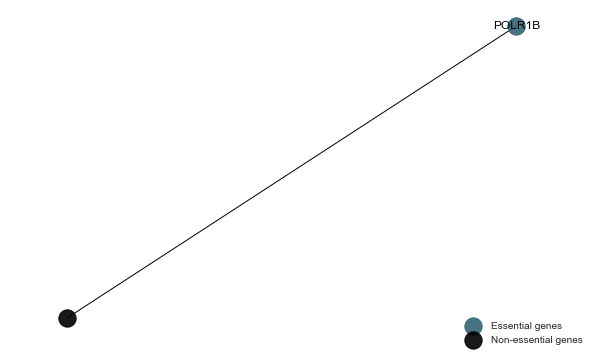

In [19]:
plt.figure(figsize=(10, 6))
pos = networkx.spring_layout(data["graph"])
networkx.draw_networkx_nodes(
  data["graph"], pos=pos,
  nodelist=list(data['essential_genes']), node_size=300,
  node_color='#316675', font_size=15, alpha=.9, label="Essential genes")
networkx.draw_networkx_nodes(
  data["graph"], pos=pos,
  nodelist=list(data['nonessential_genes']), node_size=300,
  node_color='black', font_size=15, alpha=.9, label="Non-essential genes")
networkx.draw_networkx_edges(data["graph"], pos=pos)
networkx.draw_networkx_labels(data["graph"], pos=pos, 
                              labels={e: e for e in list(data['essential_genes'])})
plt.axis('off')
plt.legend(loc='center right', fancybox=False, framealpha=0, shadow=False,
           borderpad=1, bbox_to_anchor=(1, 0), ncol=1)

## Clustering model

In [21]:
trace_dir = "../../../results/clustering_model-{}_trace".format(suffix)
with SHLM(readout, model="clustering") as model:
    trace = pm.load_trace(trace_dir, model = model.model)
    ppc_trace = pm.sample_posterior_predictive(trace, 10000, model.model)

Building cluster hierarchical model
Building two-state model


IndexError: list index out of range

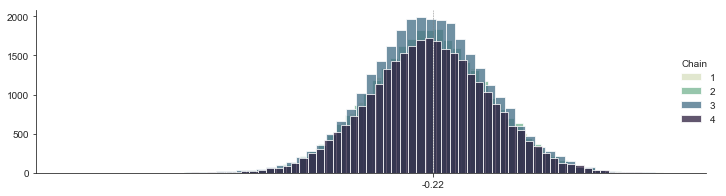

In [14]:
sp.plot_hist(trace, "gamma", 14, "");

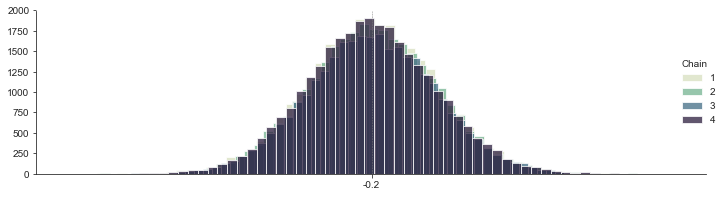

In [15]:
sp.plot_hist(trace, "gamma", 18, "");

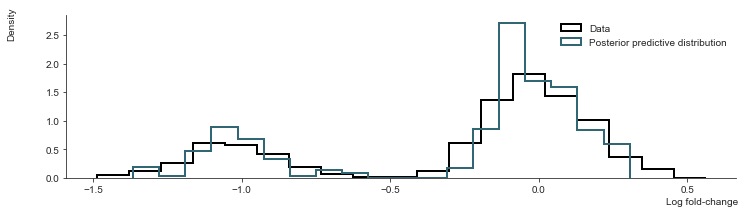

In [16]:
sp.plot_steps(readout, ppc_trace, bins=19);

In [17]:
data['gamma'][[0, 4]]

array([-0.83756546, -0.91345924])

In [18]:
numpy.mean(trace['gamma'], 0)[[14, 18]]

array([-0.22476012, -0.20000103])

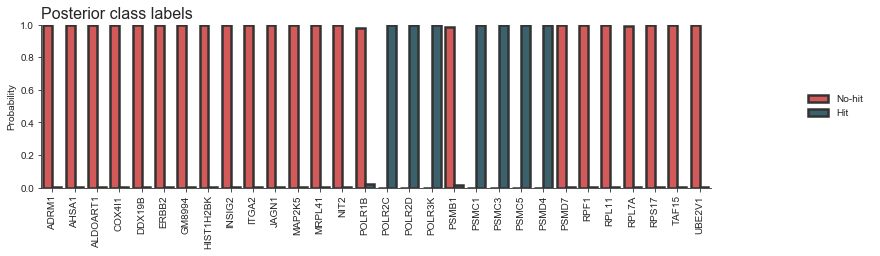

In [19]:
sp.plot_posterior_labels(
    trace, 
    [model._index_to_gene[x] for x in sorted(model._index_to_gene.keys())]);

/home/simon/miniconda3/envs/ml/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


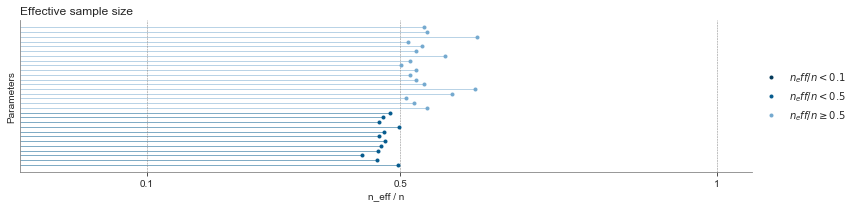

In [20]:
sp.plot_neff(trace, "gamma");

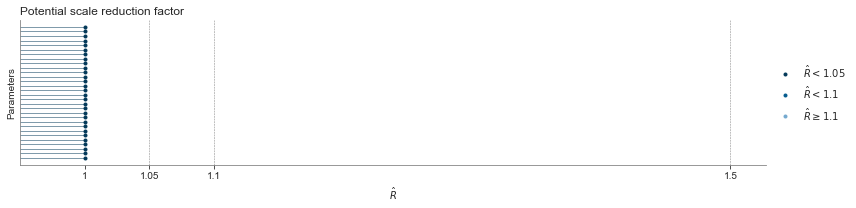

In [21]:
sp.plot_rhat(trace, "gamma");

In [22]:
np.mean(trace['gamma'], 0)[list(model._index_to_gene.keys())]

array([-0.22476012, -1.04037682, -1.04499489, -1.08365068, -0.20000103,
       -1.16229813, -0.94430302, -1.04415101, -1.04576918, -0.07595068,
        0.1656425 , -0.1338413 ,  0.00285513, -0.06002738,  0.17935712,
       -0.11787071, -0.06150235, -0.054164  ,  0.02634038, -0.00623241,
       -0.10677596,  0.06941595,  0.0472081 ,  0.1431643 ,  0.11791911,
       -0.0498032 ,  0.01404989, -0.12028241, -0.02385673,  0.0596966 ])

In [23]:
np.mean((data["gamma"] - np.mean(trace['gamma'], 0)[list(model._index_to_gene.keys())])**2)

0.03161725860300341

## MRF model

In [ ]:
readout

In [55]:
trace_dir = "../../../results/test_bin_0_trace"
with SHLM(readout, model="simple") as model:
    trace = pm.load_trace(trace_dir, model = model.model)
    #prior = pm.sample_prior_predictive(10000)
    #ppc_trace = pm.sample_posterior_predictive(trace, 10000, model.model)

Building simple hierarchical model


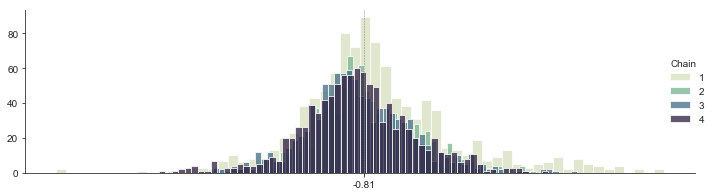

In [56]:
sp.plot_hist(trace, "gamma", 0, "");

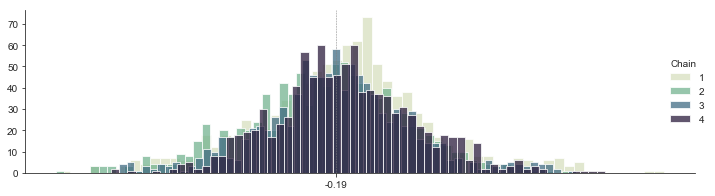

In [57]:
sp.plot_hist(trace, "gamma", 1, "");

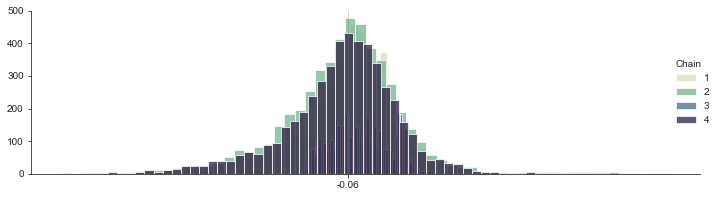

In [45]:
sp.plot_hist(trace, "beta", 0, "");

In [53]:
data['gamma']

array([-0.83756546, -0.06117564])

In [54]:
data['beta']

array([-0.05281718, -0.10729686,  0.08654076, -0.23015387])

In [51]:
numpy.mean(trace['gamma'], 0)

array([-0.82238183, -0.2517691 ])

In [52]:
numpy.mean(trace['beta'], 0)

array([-0.05818838, -0.108238  ,  0.27808383, -0.02994802])

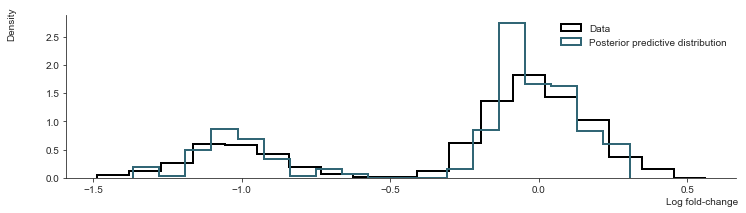

In [29]:
sp.plot_steps(readout, ppc_trace, bins=19);

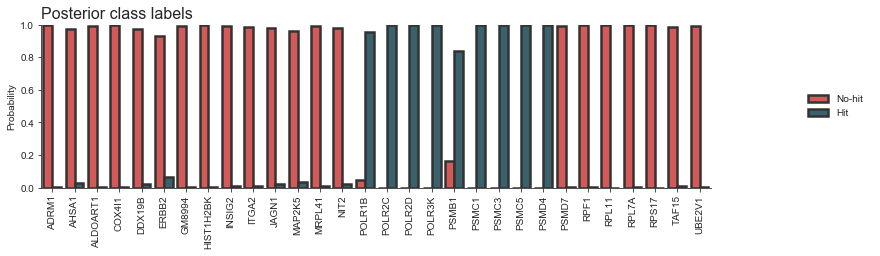

In [30]:
sp.plot_posterior_labels(
    trace,  [model._index_to_gene[x] for x in sorted(model._index_to_gene.keys())]);

/home/simon/miniconda3/envs/ml/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


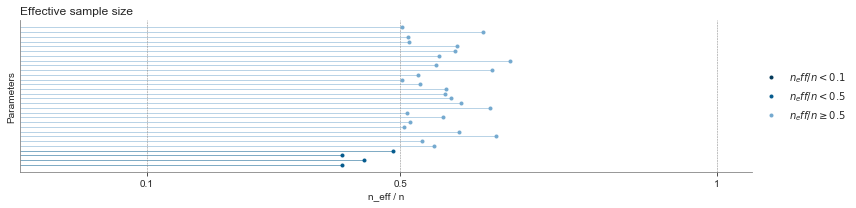

In [31]:
sp.plot_neff(trace, "gamma");

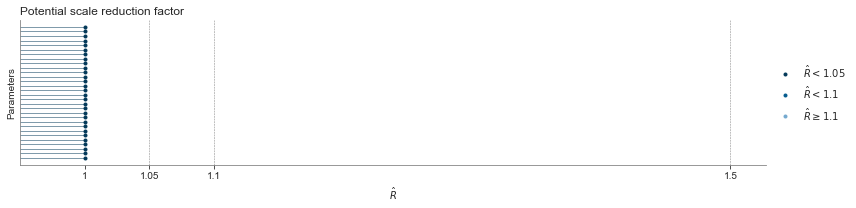

In [32]:
sp.plot_rhat(trace, "gamma");

In [33]:
np.mean((data["gamma"] - np.mean(trace['gamma'], 0)[list(model._index_to_gene.keys())])**2)

0.024646579518776388

## Model blub


In [8]:
readout_file = "../data_raw/biological_binary-data.tsv"
graph_file = "../data_raw/biological_binary-graph.pickle"

In [9]:
readout = pd.read_csv(readout_file, sep="\t")
G = read_graph(graph_file)

In [11]:
readout.shape

(27856, 8)

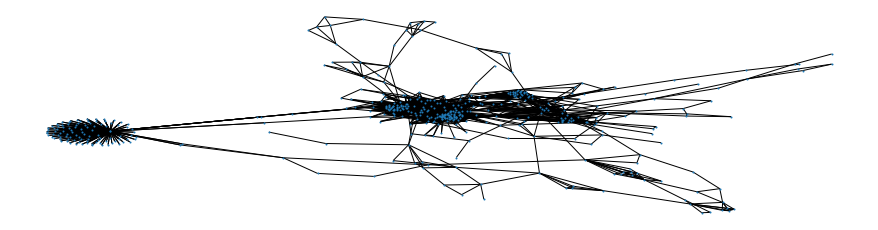

In [13]:
networkx.draw(G, node_size=1)

In [16]:
trace_dir = "../../../results/biological_binary-mrf_model_trace"
with CopynumberHLM(readout, model="mrf", graph=G, use_affinity=True) as model:
    trace = pm.load_trace(trace_dir, model = model.model)
    ppc_trace = pm.sample_posterior_predictive(trace, 10000, model.model)

Building mrf hierarchical model
100%|██████████| 10000/10000 [00:31<00:00, 312.89it/s]


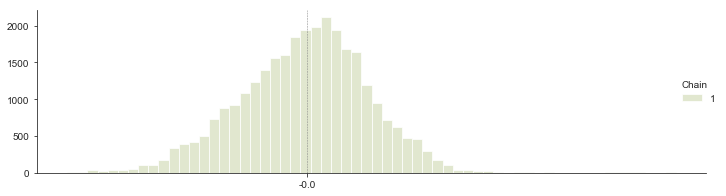

In [19]:
sp.plot_hist(trace, "gamma", 2, "");

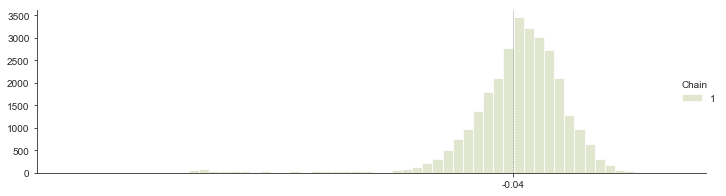

In [23]:
sp.plot_hist(trace, "gamma", 1, "");

In [24]:
model._index_to_gene.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

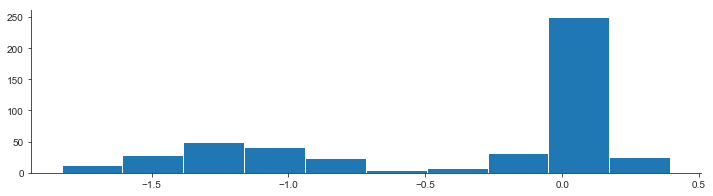

In [22]:
plt.hist(np.mean(trace['gamma'], 0)[list(model._index_to_gene.keys())]);